# Analysis Notebook (Cleaned)

> Auto-generated publication-ready version with consolidated imports, seed control, and streamlined comments.


In [1]:
# Imports consolidated for reproducibility and clarity
# === Standard library ===
from pathlib import Path
import os
import re
import re, numpy as np, pandas as pd, scanpy as sc

# === Third-party libraries ===
from scipy import sparse
from scipy.stats import mannwhitneyu
import bbknn
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc


/mnt/DATA/home/ncnst_qzw/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Reproducibility
import numpy as _np
import random as _random
_np.random.seed(42)
_random.seed(42)
try:
    import torch as _torch
    _torch.manual_seed(42)
    _torch.cuda.manual_seed_all(42)
except Exception:
    pass

### Step 1: Load data


In [3]:
# Step 1: Load data
# This cell performs a single step to ease debugging and review.
import scanpy as sc
import matplotlib as mpl
adata_RAW = sc.read_h5ad("GSE120575_TPM_proc_umap_with7genes.h5ad")
adata = sc.read_h5ad("GSE120575_TPM_proc_umap_with7genes.h5ad")


### Step 2: Load data


In [4]:
# Step 2: Load data
# This cell performs a single step to ease debugging and review.
import re
import pandas as pd
import scanpy as sc
import numpy as np

# ==== 0)  h5ad ====
adata = adata if 'adata' in globals() else sc.read_h5ad("GSE120575_TPM_proc_umap_with7genes.h5ad")

# ==== 1)  patient_id ====
def normalize_pid(s: str) -> str:
    if s is None:
        return "NA"
    s = str(s)
    #  *_T_enriched / *_myeloid_enriched
    s = re.sub(r'_(?:T|myeloid)_enriched$', '', s)
    #  _2/_3 
    s = re.sub(r'_\d+$', '', s)
    return s

# ==== 2)  adata  patient_id====
if "patient_id" not in adata.obs.columns:
    #  cell->patient GSE120575_patient_ID_single_cells.txt
    #  cell_id patient_id patient_id 
    m = pd.read_csv("GSE120575_patient_ID_single_cells.txt", sep=None, engine="python")
    cols = [c for c in m.columns if c.lower().startswith("cell")]
    col_cell = cols[0] if cols else m.columns[0]
    cols = [c for c in m.columns if "patient" in c.lower()]
    col_pid  = cols[0] if cols else m.columns[1]
    m = m[[col_cell, col_pid]].rename(columns={col_cell: "cell_id", col_pid: "patient_id"})
    m["cell_id"] = m["cell_id"].astype(str)
    #  obs_names 
    adata.obs["patient_id"] = pd.Series(m.set_index("cell_id")["patient_id"]).reindex(
        adata.obs_names.astype(str)
    ).values

# ==== 3)  ====
# patient_id_gender.txt patient_id  gender 
g = pd.read_csv("patient_id_gender.txt", sep=None, engine="python")
pid_col = [c for c in g.columns if "patient" in c.lower()][0]
gender_col = [c for c in g.columns if "gender" in c.lower()][0]
g = g[[pid_col, gender_col]].rename(columns={pid_col: "patient_id", gender_col: "gender"})
g["patient_id_norm"] = g["patient_id"].astype(str).map(normalize_pid)
g = g.drop_duplicates("patient_id_norm")

# ==== 4)  patient_id  join  ====
adata.obs["patient_id_norm"] = pd.Series(adata.obs["patient_id"].astype(str)).map(normalize_pid).values
map_gender = g.set_index("patient_id_norm")["gender"]
adata.obs["gender"] = adata.obs["patient_id_norm"].map(map_gender).fillna("Unknown").astype(str)

# ==== 5)  &  ====
print("gender Count：")
print(adata.obs["gender"].value_counts(dropna=False).sort_index())


adata.write_h5ad("GSE120575_TPM_proc_umap_with7genes_gendered.h5ad", compression="lzf")
print("Saved：GSE120575_TPM_proc_umap_with7genes_gendered.h5ad")


gender Count：
gender
Female     5407
Male      10884
Name: count, dtype: int64
Saved：GSE120575_TPM_proc_umap_with7genes_gendered.h5ad


### Step 3: Save outputs


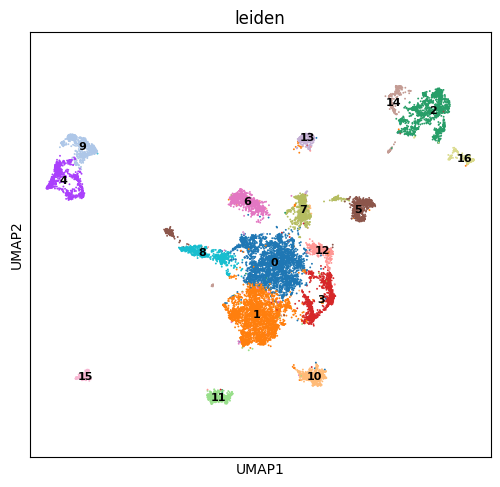

In [5]:
# Step 3: Save outputs
# This cell performs a single step to ease debugging and review.
import matplotlib.pyplot as plt
ax = sc.pl.umap(
    adata,
    color="leiden",
    legend_loc="on data",
    legend_fontsize=8,
    frameon=True,        
    show=False,
)

ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.grid(True, linewidth=0.4, alpha=0.35)
ax.set_aspect("equal", adjustable="datalim")  
plt.margins(0.04)
plt.tight_layout()
ax.figure.set_size_inches(5, 5)
ax.figure.savefig("umap_leiden_axes.png", dpi=300)
ax.figure.savefig("umap_leiden_axes.pdf")
plt.show()


### Step 4: Visualization settings / plotting


In [6]:
# Step 4: Visualization settings / plotting
# This cell performs a single step to ease debugging and review.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scanpy as sc

assert "patient_id" in adata.obs, "no patient_id in adata.obs"
assert "X_umap" in adata.obsm_keys(), "UAMP_Fig"

# 1) >20 
cats = adata.obs["patient_id"].astype("category")
adata.obs["patient_id"] = cats 
levels = list(cats.cat.categories)
n = len(levels)

def distinct_palette(n):
    if n <= 20:
        cmap = mpl.cm.get_cmap("tab20", n)
        colors = [mpl.colors.to_hex(cmap(i)) for i in range(n)]
    else:
        #  HSV /
        colors = [mpl.colors.to_hex(mpl.colors.hsv_to_rgb((i/n, 0.65, 0.9))) for i in range(n)]
    return colors

palette = distinct_palette(n)
adata.uns["patient_id_colors"] = palette


### Step 5: Save outputs


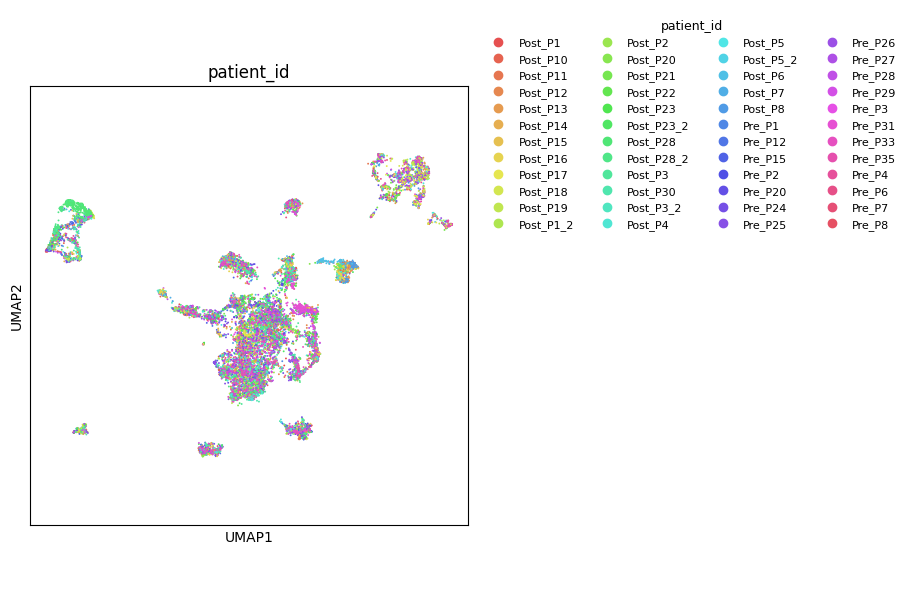

In [7]:
# Step 5: Save outputs
# This cell performs a single step to ease debugging and review.
import matplotlib.pyplot as plt
import matplotlib as mpl
import scanpy as sc

levels = list(adata.obs["patient_id"].cat.categories)
n = len(levels)
palette = adata.uns["patient_id_colors"]

# 1) =UMAP=
fig = plt.figure(figsize=(9,6), constrained_layout=True)
gs  = fig.add_gridspec(1, 2, width_ratios=[1, 0.9]) 

ax = fig.add_subplot(gs[0,0])
sc.pl.umap(adata, color="patient_id", frameon=True, legend_loc=None, ax=ax, show=False)
ax.set_xlabel("UMAP1"); ax.set_ylabel("UMAP2")
ax.grid(True, linewidth=0.4, alpha=0.35)
ax.set_box_aspect(1)                 
ax.set_aspect("equal", adjustable="datalim")
plt.margins(0.04)

# 2) 
ax_leg = fig.add_subplot(gs[0,1])
ax_leg.axis("off")
handles = [mpl.lines.Line2D([0],[0], marker='o', linestyle='', color=palette[i],
                            label=levels[i], markersize=6) for i in range(n)]
cols = 4 if n > 24 else 2
ax_leg.legend(handles=handles, title="patient_id", ncol=cols,
              loc="upper left", frameon=False, fontsize=8, title_fontsize=9)

fig.savefig("umap_patient_square.png", dpi=300, bbox_inches="tight")
fig.savefig("umap_patient_square.pdf", bbox_inches="tight")
plt.show()


### Step 6: Transform expression (log1p)


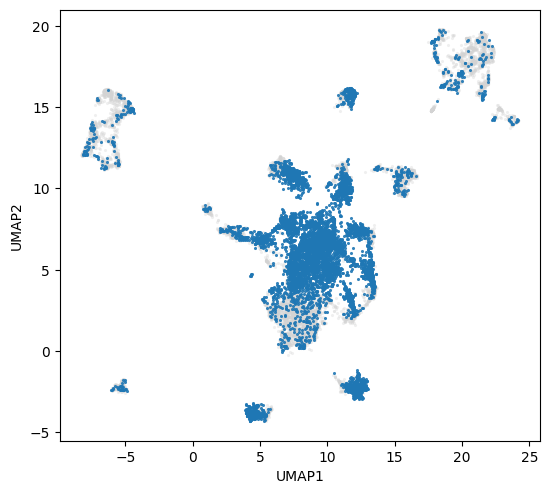

In [8]:
# Step 6: Transform expression (log1p)
# This cell performs a single step to ease debugging and review.
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

assert "X_umap" in adata.obsm_keys(), "UMAP Frist, Plz"
genes_need = [g for g in ["CD8A","CD8B"] if g in adata.var_names]
assert genes_need, "No CD8A/CD8B"

# 1) / log1p(TPM) > 0 
def get_expr(g):
    v = adata[:, g].X
    if hasattr(v, "toarray"): v = v.toarray()
    v = np.asarray(v).reshape(-1)
    return v

exprs = [get_expr(g) for g in genes_need]
pos_mask = np.any([v > 0 for v in exprs], axis=0) 

#  obs 
adata.obs["CD8T_flag"] = np.where(pos_mask, "CD8T", "Other")

# 2) CD8T 
Xumap = adata.obsm["X_umap"]
fig, ax = plt.subplots(figsize=(6.2, 5.6))

ax.scatter(Xumap[~pos_mask, 0], Xumap[~pos_mask, 1], s=5, c="lightgray", alpha=0.35, linewidths=0)

#  CD8T
ax.scatter(Xumap[pos_mask, 0], Xumap[pos_mask, 1], s=5, c="#1f77b4", alpha=0.9, linewidths=0, label="CD8T (CD8A/CD8B+)")

ax.set_xlabel("UMAP1"); ax.set_ylabel("UMAP2")
ax.grid(False)

plt.show()


### Step 7: Load data


CD8T cells: 7331
 100.0%


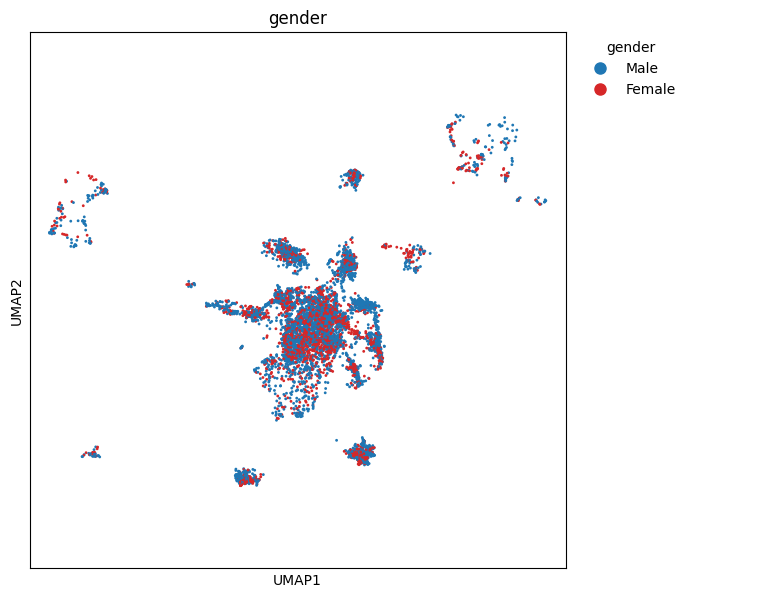

In [9]:
# Step 7: Load data
# This cell performs a single step to ease debugging and review.
import re, numpy as np, pandas as pd, scanpy as sc
import matplotlib.pyplot as plt
import matplotlib as mpl

# === 0)  ===
sex_df = pd.read_csv("patient_id_gender.txt", sep="\t", dtype=str)
sex_df.columns = ["patient_id","gender"]
sex_df["patient_id"] = sex_df["patient_id"].str.strip()
sex_df["gender"] = sex_df["gender"].str.strip().str.title()  # Male/Female

# === 1)  CD8T  adata  ===
A = adata_cd8 if "adata_cd8" in globals() else None
if A is None:
    #  CD8TCD8A  CD8B > 0 log1p(TPM)
    need = [g for g in ["CD8A","CD8B"] if g in adata.var_names]
    assert need, "当前数据中找不到 CD8A/CD8B"
    def col(ad, g):
        v = ad[:, g].X
        if hasattr(v, "toarray"): v = v.toarray()
        return np.asarray(v).ravel()
    mask = np.any([col(adata,g) > 0 for g in need], axis=0)
    A = adata[mask].copy()

print(f"CD8T cells: {A.n_obs}")

# === 2)  patient_id  *_enriched  ===
def merge_pid(pid: str) -> str:
    s = str(pid)
    s = re.sub(r'_(T|myeloid|B|NK|DC)_enriched$', '', s, flags=re.I)
    return s

A.obs["patient_id_merged"] = A.obs["patient_id"].astype(str).map(merge_pid)

# === 3)  merged  Unknown ===
sex_map_exact  = dict(zip(sex_df["patient_id"], sex_df["gender"]))
sex_map_merged = dict(zip(sex_df["patient_id"].map(merge_pid), sex_df["gender"]))

gender = A.obs["patient_id"].map(sex_map_exact)
missing = gender.isna()
if missing.any():
    gender.loc[missing] = A.obs.loc[missing, "patient_id_merged"].map(sex_map_merged)

gender = gender.fillna("Unknown").astype("category")
cat_order = [c for c in ["Male","Female","Unknown"] if c in gender.cat.categories]
gender = gender.cat.reorder_categories(cat_order)
A.obs["gender"] = gender

unmatched = sorted(A.obs.loc[A.obs["gender"]=="Unknown","patient_id"].unique().tolist())
print(f" {(A.obs['gender']!='Unknown').mean():.1%}")
if unmatched: print("no patient_id:", unmatched[:10])

# === 4) UMAP +  ===
palette = {"Male":"#1f77b4","Female":"#d62728","Unknown":"#7f7f7f"}
A.uns["gender_colors"] = [palette[c] for c in A.obs["gender"].cat.categories]

fig = plt.figure(figsize=(7.6, 5.8), constrained_layout=True)
gs  = fig.add_gridspec(1, 2, width_ratios=[1, 0.35])

ax = fig.add_subplot(gs[0,0])
sc.pl.umap(A, color="gender", frameon=True, legend_loc=None, ax=ax, show=False)
ax.set_xlabel("UMAP1"); ax.set_ylabel("UMAP2")
ax.grid(True, linewidth=0.4, alpha=0.35)
ax.set_aspect("equal", adjustable="datalim"); ax.set_box_aspect(1)
plt.margins(0.04)

ax_leg = fig.add_subplot(gs[0,1]); ax_leg.axis("off")
handles = [mpl.lines.Line2D([0],[0], marker='o', linestyle='', color=palette[c],
                            label=c, markersize=8) for c in A.obs["gender"].cat.categories]
ax_leg.legend(handles=handles, title="gender", loc="upper left", frameon=False)

fig.savefig("umap_CD8T_by_gender_square.png", dpi=300, bbox_inches="tight")
fig.savefig("umap_CD8T_by_gender_square.pdf", bbox_inches="tight")
plt.show()


### Step 8: Select highly variable genes


Male CD8T: 5049 cells;  Female CD8T: 2282 cells


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


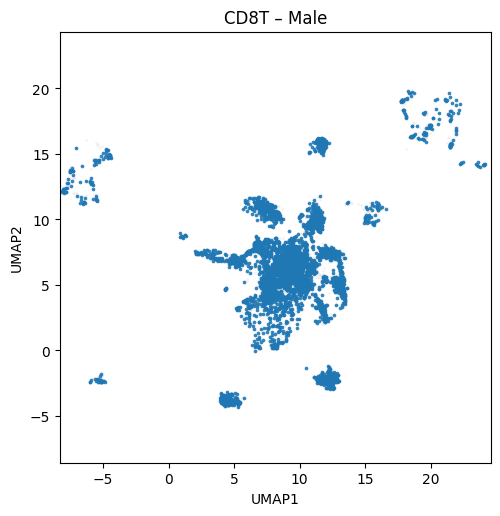

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


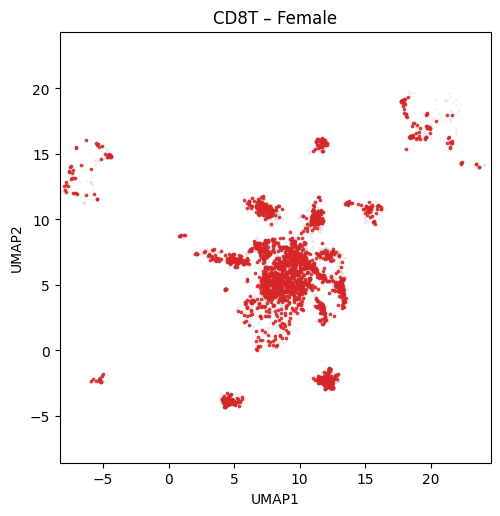

In [10]:
# Step 8: Select highly variable genes
# This cell performs a single step to ease debugging and review.
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

#  CD8T  A
A = adata_cd8 if "adata_cd8" in globals() else A

assert "gender" in A.obs, "no gender "
assert "X_umap" in A.obsm, " CD8T  UMAP"

#  UMAPTrue=False=
recompute = False

xy = A.obsm["X_umap"]
xlim = (float(np.min(xy[:,0]))*1.02, float(np.max(xy[:,0]))*1.02)
ylim = (float(np.min(xy[:,1]))*1.02, float(np.max(xy[:,1]))*1.02)

def plot_one(sub, title, out_prefix, color="#1f77b4"):
    B = sub.copy()
    if recompute:
        # HVG/PCA/BBKNN(or neighbors)/UMAP
        sc.pp.filter_genes(B, min_cells=max(1, int(0.01*B.n_obs)))
        if B.X.max() > 50: sc.pp.log1p(B)
        sc.pp.highly_variable_genes(B, n_top_genes=3000, flavor="seurat", subset=True)
        sc.pp.scale(B, max_value=10); sc.tl.pca(B, svd_solver="arpack")
        try:
            import bbknn; bbknn.bbknn(B, batch_key="patient_id")
        except Exception:
            sc.pp.neighbors(B, n_neighbors=15, n_pcs=30)
        sc.tl.umap(B)

    bg_mask = ~A.obs_names.isin(B.obs_names)
    fig, ax = plt.subplots(figsize=(5.8, 5.6))
    ax.scatter(A.obsm["X_umap"][bg_mask,0], A.obsm["X_umap"][bg_mask,1],
               s=4, c="lightgray", alpha=0.25, linewidths=0)
    ax.scatter(B.obsm["X_umap"][:,0], B.obsm["X_umap"][:,1],
               s=7, c=color, alpha=0.9, linewidths=0)
    ax.set_title(title)
    ax.set_xlabel("UMAP1"); ax.set_ylabel("UMAP2")
    ax.grid(False)
    ax.set_aspect("equal", adjustable="datalim"); ax.set_box_aspect(1)
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    plt.margins(0.04)
    fig.savefig(f"{out_prefix}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"{out_prefix}.pdf", bbox_inches="tight")
    plt.show()
    return B

male  = A[A.obs["gender"] == "Male"]
female= A[A.obs["gender"] == "Female"]

print(f"Male CD8T: {male.n_obs} cells;  Female CD8T: {female.n_obs} cells")

male  = plot_one(male,   "CD8T – Male",   "umap_CD8T_male",   color="#1f77b4")
female= plot_one(female, "CD8T – Female", "umap_CD8T_female", color="#d62728")


### Step 9: Load data


In [11]:
# Step 9: Load data
# This cell performs a single step to ease debugging and review.
import scanpy as sc
import numpy as np
import pandas as pd

A = A  

print("has gender:", "gender" in A.obs)
print("has X_umap:", "X_umap" in A.obsm)
print("CD274 in obs:", "CD274_log1p" in A.obs, "or", "CD274_TPM" in A.obs)
print("CD274 in var/raw:", ("CD274" in A.var_names), (A.raw is not None and "CD274" in A.raw.var_names))

# 1)  gender patient_id 
if "gender" not in A.obs:
    import re
    g = pd.read_csv("patient_id_gender.txt", sep=None, engine="python")
    pid_col = [c for c in g.columns if "patient" in c.lower()][0]
    gender_col = [c for c in g.columns if "gender" in c.lower()][0]
    g = g[[pid_col, gender_col]].rename(columns={pid_col: "patient_id", gender_col: "gender"})
    def norm_pid(s):
        s = str(s)
        s = re.sub(r'_(?:T|myeloid)_enriched$', '', s)
        s = re.sub(r'_\d+$', '', s)
        return s
    if "patient_id" not in A.obs:
        m = pd.read_csv("GSE120575_patient_ID_single_cells.txt", sep=None, engine="python")
        col_cell = [c for c in m.columns if c.lower().startswith("cell")][0]
        col_pid  = [c for c in m.columns if "patient" in c.lower()][0]
        A.obs["patient_id"] = pd.Series(m.set_index(col_cell)[col_pid]).reindex(A.obs_names.astype(str)).values
    A.obs["patient_id_norm"] = pd.Series(A.obs["patient_id"].astype(str)).map(norm_pid).values
    g["patient_id_norm"] = g["patient_id"].astype(str).map(norm_pid)
    map_gender = g.drop_duplicates("patient_id_norm").set_index("patient_id_norm")["gender"]
    A.obs["gender"] = A.obs["patient_id_norm"].map(map_gender).fillna("Unknown").astype(str)
    print("merged gender. counts:\n", A.obs["gender"].value_counts())

# 2)  UMAP HVG 
if "X_umap" not in A.obsm:
    #  log1p 
    B = A.copy()
    if "log1p" in B.layers:
        B.X = B.layers["log1p"].copy()
    sc.pp.highly_variable_genes(B, n_top_genes=min(3000, max(1, B.n_vars-1)), subset=False, flavor="seurat")
    B = B[:, B.var["highly_variable"]].copy()
    sc.pp.scale(B, max_value=10)
    sc.tl.pca(B, svd_solver="arpack")
    sc.pp.neighbors(B, n_neighbors=30, n_pcs=50, metric="cosine")
    sc.tl.umap(B)
    A.obsm["X_umap"] = B.obsm["X_umap"]

# 3)  CD274 obs raw/var
def get_cd274_log1p(ad):
    if "CD274_log1p" in ad.obs:
        return ad.obs["CD274_log1p"].to_numpy(float)
    if "CD274_TPM" in ad.obs:
        return np.log1p(ad.obs["CD274_TPM"].to_numpy(float))
    if "CD274" in ad.var_names:
        j = ad.var_names.get_loc("CD274"); x = ad.X[:, j]
        x = x.toarray() if hasattr(x, "toarray") else x
        return np.log1p(np.asarray(x).ravel()) if np.nanmax(x) > 50 else np.asarray(x).ravel()
    if ad.raw is not None and "CD274" in ad.raw.var_names:
        j = ad.raw.var_names.get_loc("CD274"); x = ad.raw.X[:, j]
        x = x.toarray() if hasattr(x, "toarray") else x
        return np.log1p(np.asarray(x).ravel()) if np.nanmax(x) > 50 else np.asarray(x).ravel()
    raise KeyError("no CD274")

cd274_log1p = get_cd274_log1p(A)
print("CD274_log1p shape:", cd274_log1p.shape)


has gender: True
has X_umap: True
CD274 in obs: True or True
CD274 in var/raw: False False
CD274_log1p shape: (7331,)


### Step 10: Transform expression (log1p)


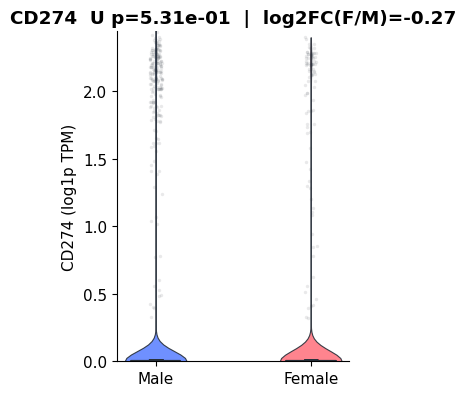

[Saved] violin_CD274_Male_vs_Female.png / .pdf


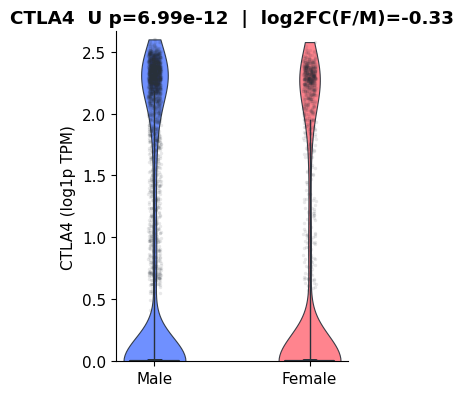

[Saved] violin_CTLA4_Male_vs_Female.png / .pdf


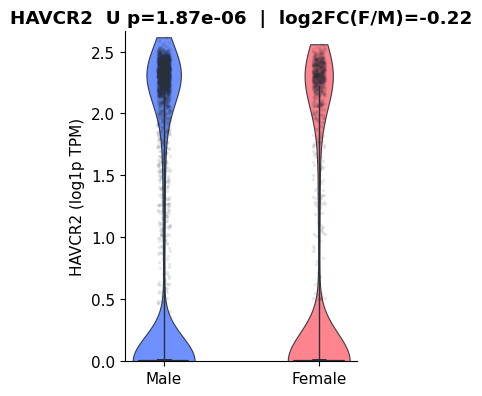

[Saved] violin_HAVCR2_Male_vs_Female.png / .pdf


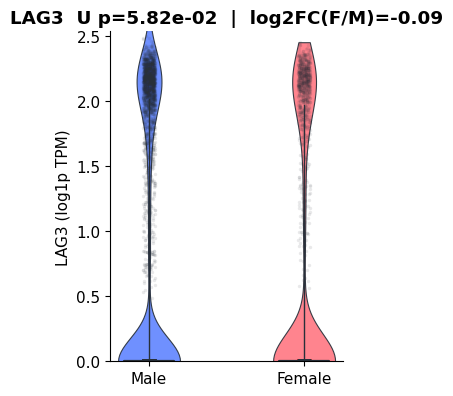

[Saved] violin_LAG3_Male_vs_Female.png / .pdf


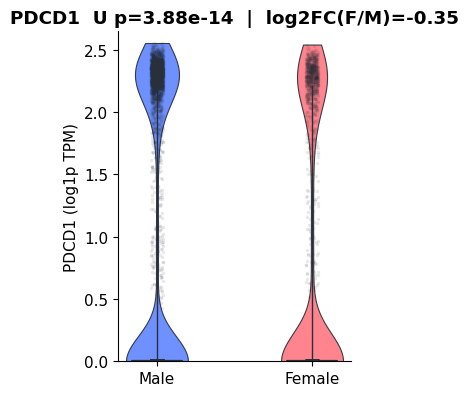

[Saved] violin_PDCD1_Male_vs_Female.png / .pdf


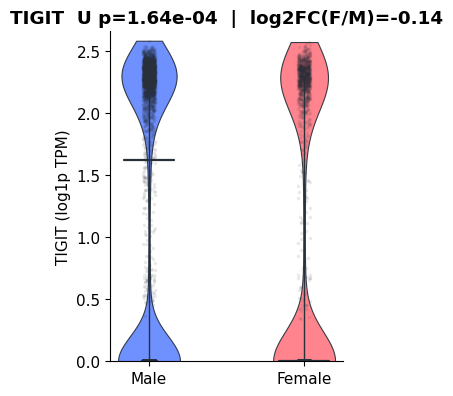

[Saved] violin_TIGIT_Male_vs_Female.png / .pdf


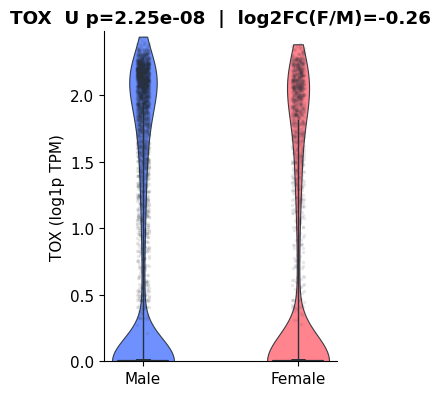

[Saved] violin_TOX_Male_vs_Female.png / .pdf


In [12]:
# Step 10: Transform expression (log1p)
# This cell performs a single step to ease debugging and review.
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# =====  =====
GENES = ['CD274','CTLA4','HAVCR2','LAG3','PDCD1','TIGIT','TOX']  
FIGSIZE = (3.2, 4.1)    
VIOLIN_WIDTH = 0.40     
JITTER = 0.08            
SEED = 42               

# /
COL_M = "#6387FF"   
COL_F = "#FF7A85"   
EDGE  = "#28303a"

mpl.rcParams.update({
    "font.size": 11,
    "axes.linewidth": 0.8,
    "axes.titleweight": "semibold",
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8,
    "grid.alpha": 0.25,
    "grid.linewidth": 0.5,
})

assert "gender" in A.obs, "A.obs no gender"
male_mask   = A.obs["gender"].astype(str).str.lower().eq("male").to_numpy()
female_mask = A.obs["gender"].astype(str).str.lower().eq("female").to_numpy()

def get_vals(ad, gene):
    """return (mlog, flog, mlin, flin)：log1p(TPM) """
    if f"{gene}_log1p" in ad.obs:
        v_log = ad.obs[f"{gene}_log1p"].to_numpy(float)
        v_lin = np.expm1(v_log)
    elif f"{gene}_TPM" in ad.obs:
        v_lin = ad.obs[f"{gene}_TPM"].to_numpy(float)
        v_log = np.log1p(v_lin)
    else:
        #  var/raw
        if gene in ad.var_names:
            Xg = ad.X[:, ad.var_names.get_loc(gene)]
        elif ad.raw is not None and (gene in getattr(ad.raw, "var_names", [])):
            Xg = ad.raw.X[:, ad.raw.var_names.get_loc(gene)]
        else:
            return np.array([]), np.array([]), np.array([]), np.array([])
        if hasattr(Xg, "toarray"): Xg = Xg.toarray()
        v = np.asarray(Xg).ravel().astype(float)
        if np.nanmax(v) > 50: v_lin, v_log = v, np.log1p(v)
        else:                 v_log, v_lin = v, np.expm1(v)
    v_log = np.nan_to_num(v_log, nan=0.0, posinf=0.0, neginf=0.0)
    v_lin = np.nan_to_num(v_lin, nan=0.0, posinf=0.0, neginf=0.0)
    return v_log[male_mask], v_log[female_mask], v_lin[male_mask], v_lin[female_mask]

def draw_one(gene, figsize=FIGSIZE, width=VIOLIN_WIDTH, jitter=JITTER):
    mlog, flog, mlin, flin = get_vals(A, gene)
    if mlog.size + flog.size == 0:
        print(f"skip {gene}: no find"); return

    eps = 1e-9
    m_mean = float(mlin.mean()) if mlin.size else np.nan
    f_mean = float(flin.mean()) if flin.size else np.nan
    log2fc = np.log2((f_mean + eps)/(m_mean + eps)) if np.isfinite([m_mean,f_mean]).all() else np.nan
    U, p = (mannwhitneyu(mlog, flog, alternative="two-sided") if (mlog.size and flog.size) else (np.nan, np.nan))

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)

    parts = ax.violinplot([mlog, flog],
                          positions=[1,2],
                          widths=width,
                          showmeans=False, showextrema=False, showmedians=False)
    for i, pc in enumerate(parts['bodies']):
        pc.set_alpha(0.92)
        pc.set_edgecolor(EDGE)
        pc.set_linewidth(0.8)
        pc.set_facecolor(COL_M if i == 0 else COL_F)

    def add_quartile(x, arr, color=EDGE):
        if arr.size == 0: return
        q1, med, q3 = np.percentile(arr, [25,50,75])
        ax.plot([x-0.16, x+0.16], [med, med], color=color, lw=1.6, solid_capstyle="round")
        ax.plot([x, x], [q1, q3], color=color, lw=1.0)

    add_quartile(1, mlog); add_quartile(2, flog)

    #  jitter=None
    if jitter and (mlog.size or flog.size):
        rng = np.random.default_rng(SEED)
        ax.scatter(1 + (rng.random(mlog.size)-0.5)*jitter, mlog, s=6, c=EDGE, alpha=0.10, linewidths=0)
        ax.scatter(2 + (rng.random(flog.size)-0.5)*jitter, flog, s=6, c=EDGE, alpha=0.10, linewidths=0)

    ax.set_xticks([1,2]); ax.set_xticklabels(["Male","Female"])
    ax.set_xlim(0.75, 2.25)          
    ax.set_ylabel(f"{gene} (log1p TPM)")

    title = f"{gene}  U p={p:.2e}" if np.isfinite(p) else f"{gene}  U p=NA"
    if np.isfinite(log2fc): title += f"  |  log2FC(F/M)={log2fc:.2f}"
    ax.set_title(title)

    ymax = np.nanpercentile(np.r_[mlog, flog], 99.5) if (mlog.size and flog.size) else np.nanmax(np.r_[mlog, flog])
    if np.isfinite(ymax): ax.set_ylim(0, ymax*1.06)

    for sp in ["top","right"]:
        ax.spines[sp].set_visible(False)

    fig.tight_layout()
    fig.savefig(f"violin_{gene}_Male_vs_Female.png", dpi=300, bbox_inches="tight", pad_inches=0.02)
    fig.savefig(f"violin_{gene}_Male_vs_Female.pdf", bbox_inches="tight", pad_inches=0.02)
    plt.show()
    print(f"[Saved] violin_{gene}_Male_vs_Female.png / .pdf")

for g in GENES:
    draw_one(g)


### Step 11: Transform expression (log1p)


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


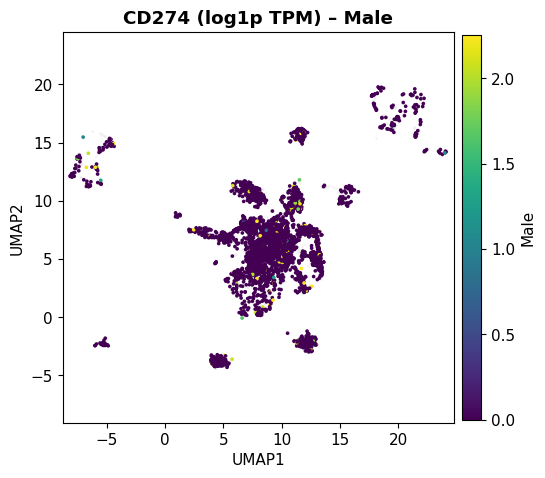

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


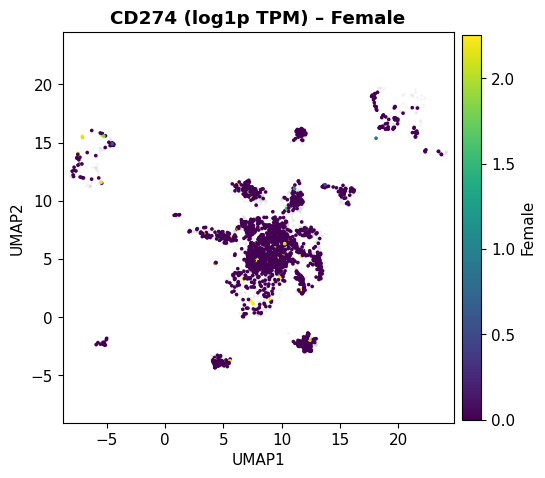

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


[OK] CD274


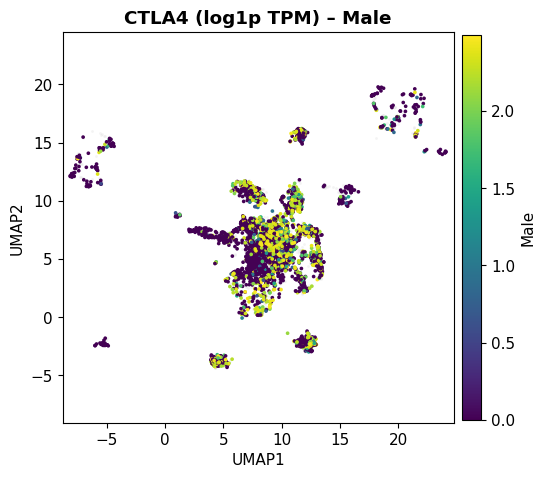

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


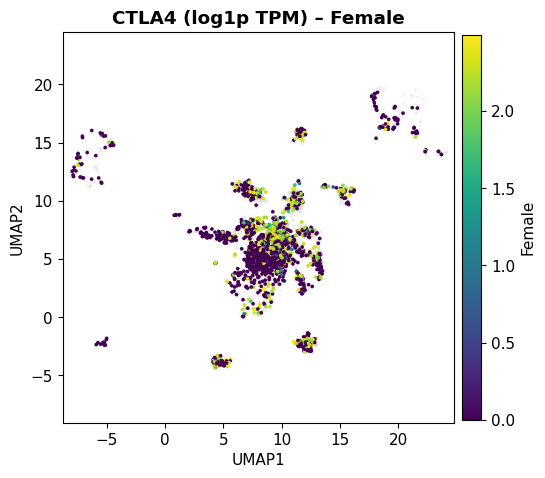

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


[OK] CTLA4


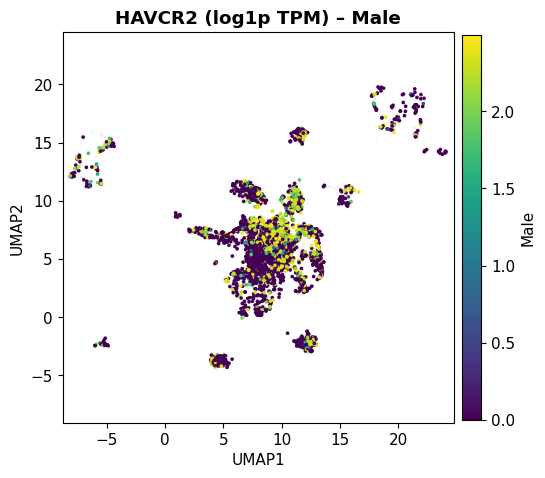

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


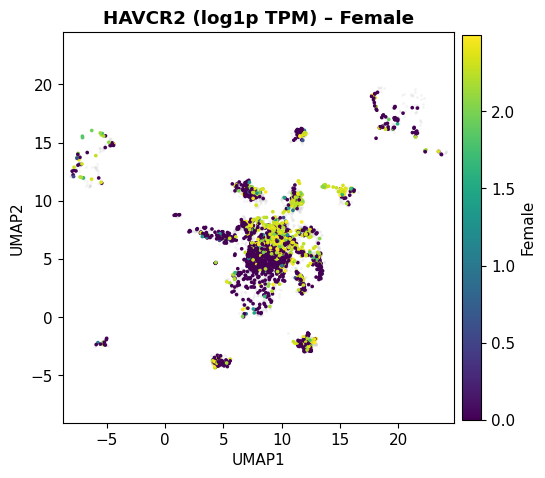

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


[OK] HAVCR2


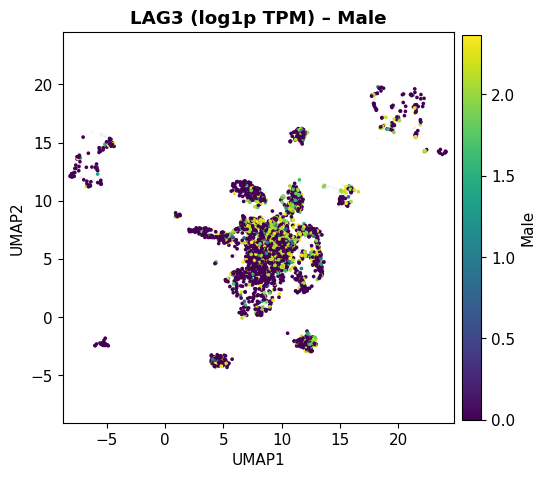

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


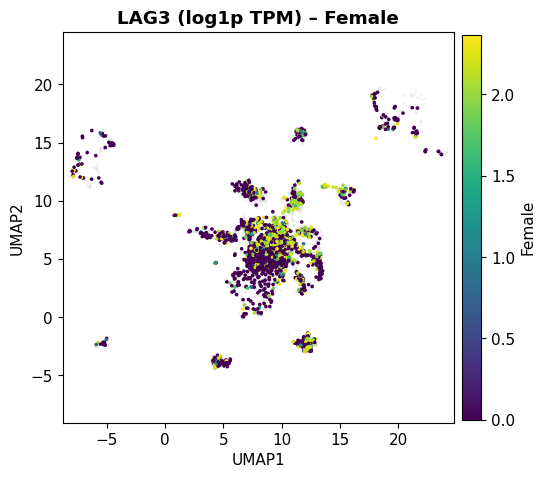

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


[OK] LAG3


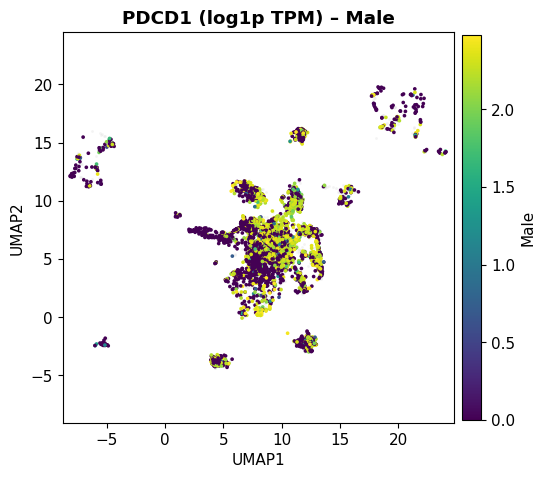

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


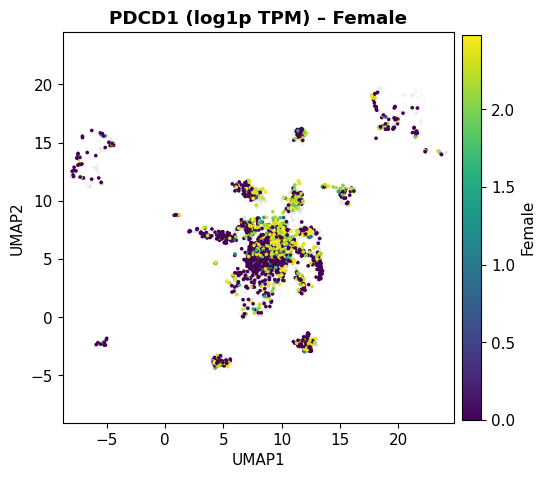

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


[OK] PDCD1


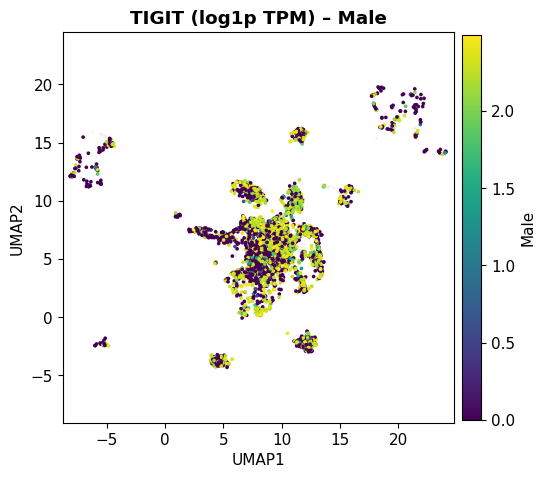

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


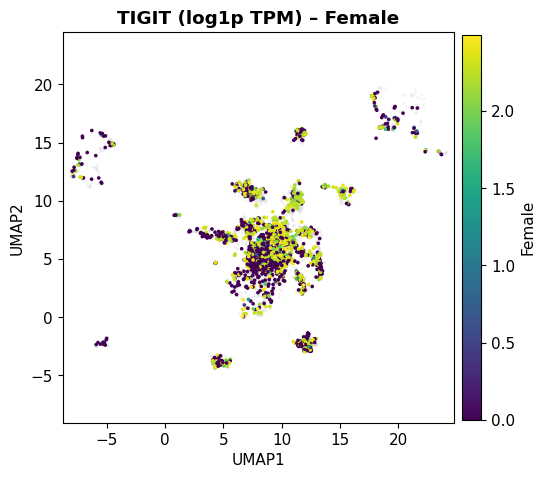

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


[OK] TIGIT


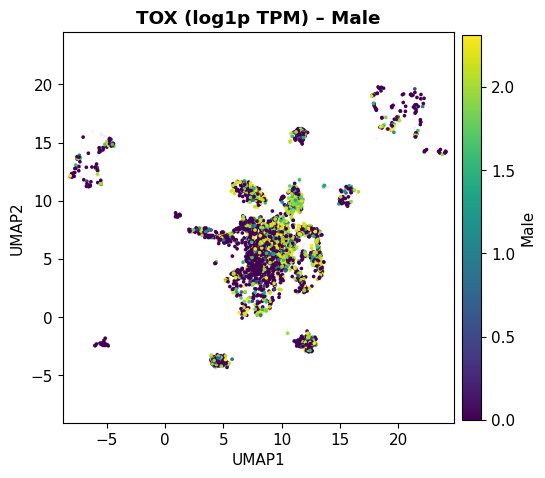

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


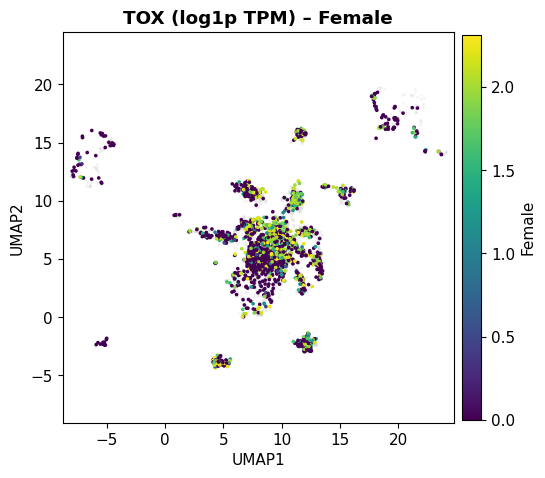

[OK] TOX

Saved：umap_gender_by_gene/png 与 umap_gender_by_gene/pdf


In [13]:
# Step 11: Transform expression (log1p)
# This cell performs a single step to ease debugging and review.
import os
import numpy as np
import matplotlib.pyplot as plt

# =========  =========
GENES   = ['CD274','CTLA4','HAVCR2','LAG3','PDCD1','TIGIT','TOX']
OUTDIR  = Path("umap_gender_by_gene")   
OUT_PNG = OUTDIR / "png"
OUT_PDF = OUTDIR / "pdf"
OUT_PNG.mkdir(parents=True, exist_ok=True)
OUT_PDF.mkdir(parents=True, exist_ok=True)

assert "gender" in A.obs and "X_umap" in A.obsm

XY   = A.obsm["X_umap"]
PAD  = 0.02
xlim = (XY[:,0].min() - PAD*np.ptp(XY[:,0]), XY[:,0].max() + PAD*np.ptp(XY[:,0]))
ylim = (XY[:,1].min() - PAD*np.ptp(XY[:,1]), XY[:,1].max() + PAD*np.ptp(XY[:,1]))

male_mask   = A.obs["gender"].astype(str).str.lower().eq("male").to_numpy()
female_mask = A.obs["gender"].astype(str).str.lower().eq("female").to_numpy()

def get_log1p(A, gene):
    if f"{gene}_log1p" in A.obs:
        return A.obs[f"{gene}_log1p"].to_numpy(float)
    if f"{gene}_TPM" in A.obs:
        v = A.obs[f"{gene}_TPM"].to_numpy(float)
        return np.log1p(v)
    #  var/raw
    if gene in A.var_names:
        Xg = A.X[:, A.var_names.get_loc(gene)]
    elif A.raw is not None and (gene in getattr(A.raw, "var_names", [])):
        Xg = A.raw.X[:, A.raw.var_names.get_loc(gene)]
    else:
        raise KeyError(f"{gene} no（obs/var/raw）中")
    if sparse.issparse(Xg): Xg = Xg.toarray()
    Xg = np.asarray(Xg).ravel()
    return (np.log1p(Xg) if np.nanmax(Xg) > 50 else Xg)

def plot_and_save(expr, mask, title, png_path, pdf_path, cmap="viridis",
                  figsize=(5.4,5.2), dot_bg=4, dot_fg=7, vmin=None, vmax=None):
    fig, ax = plt.subplots(figsize=figsize)
    bg = ~mask
    ax.scatter(XY[bg,0], XY[bg,1], s=dot_bg, c="lightgray", alpha=0.25, linewidths=0)
    sca = ax.scatter(XY[mask,0], XY[mask,1], s=dot_fg, c=expr[mask],
                     vmin=vmin, vmax=vmax, cmap=cmap, linewidths=0)
    ax.set_title(title)
    ax.set_xlabel("UMAP1"); ax.set_ylabel("UMAP2")
    ax.set_aspect("equal", adjustable="datalim"); ax.set_box_aspect(1)
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    ax.grid(False)
    cb = plt.colorbar(sca, ax=ax, fraction=0.046, pad=0.02)
    cb.set_label(title.split("–")[-1].strip())  
    fig.savefig(png_path, dpi=300, bbox_inches="tight")
    fig.savefig(pdf_path,            bbox_inches="tight")
    plt.show()

# ===== Male/Female =====
for g in GENES:
    try:
        expr = get_log1p(A, g)
        expr = np.nan_to_num(expr, nan=0.0, posinf=0.0, neginf=0.0)
        finite = np.isfinite(expr)
        vmin, vmax = np.percentile(expr[finite], 1), np.percentile(expr[finite], 99)
        if vmin == vmax: vmax = vmin + 1e-6

        # Male
        plot_and_save(
            expr, male_mask,
            title=f"{g} (log1p TPM) – Male",
            png_path=OUT_PNG / f"umap_CD8T_male_{g}.png",
            pdf_path=OUT_PDF / f"umap_CD8T_male_{g}.pdf",
            vmin=vmin, vmax=vmax
        )
        # Female
        plot_and_save(
            expr, female_mask,
            title=f"{g} (log1p TPM) – Female",
            png_path=OUT_PNG / f"umap_CD8T_female_{g}.png",
            pdf_path=OUT_PDF / f"umap_CD8T_female_{g}.pdf",
            vmin=vmin, vmax=vmax
        )
        print(f"[OK] {g}")
    except KeyError as e:
        print(f"[Skip] {g}: {e}")
    
print(f"\nSaved：{OUTDIR}/png 与 {OUTDIR}/pdf")
